# Imports and Constants

In [23]:
from mtgsdk import Card as crd
from IPython.display import display, Image
from PIL import Image
from os import listdir
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.utils import shuffle
import requests
import io
import os
import pickle as pkl
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

DATA_DIR="Data"
IMAGE_PATH="{}/Images"

# Getting the Database

Run this cell if you do not have an up to date cardData.csv file in your data directory.

In [8]:
cards = crd.all()
cDict = [c.__dict__ for c in cards]
df = pd.DataFrame(cDict)
if(not os.path.exists(DATA_DIR)):
    os.makedirs(DATA_DIR)
df.to_csv('Data/cardData.csv', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35983 entries, 0 to 35982
Data columns (total 39 columns):
artist            35983 non-null object
border            22 non-null object
cmc               35983 non-null float64
color_identity    31897 non-null object
colors            28223 non-null object
flavor            21356 non-null object
foreign_names     23871 non-null object
hand              116 non-null float64
id                35983 non-null object
image_url         33753 non-null object
layout            35983 non-null object
legalities        35171 non-null object
life              116 non-null float64
loyalty           203 non-null float64
mana_cost         31671 non-null object
multiverse_id     33753 non-null float64
name              35983 non-null object
names             475 non-null object
number            29781 non-null object
original_text     33298 non-null object
original_type     34034 non-null object
power             16760 non-null object
printings        

Run this cell if you already have the csv file.

In [2]:
df = pd.read_csv("Data/cardData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35983 entries, 0 to 35982
Data columns (total 40 columns):
Unnamed: 0        35983 non-null int64
artist            35983 non-null object
border            22 non-null object
cmc               35983 non-null float64
color_identity    31897 non-null object
colors            28223 non-null object
flavor            21356 non-null object
foreign_names     23871 non-null object
hand              116 non-null float64
id                35983 non-null object
image_url         33753 non-null object
layout            35983 non-null object
legalities        35171 non-null object
life              116 non-null float64
loyalty           203 non-null float64
mana_cost         31671 non-null object
multiverse_id     33753 non-null float64
name              35983 non-null object
names             475 non-null object
number            29781 non-null object
original_text     33298 non-null object
original_type     34034 non-null object
power             

C:\Users\JWinters\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2,18,25,29,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<h3>Trim dataframe to Contain Only Card Name and Image Path of Correct Set</h3>

In [3]:
df[["name", "image_url"]].head(10)
dftemp = df.loc[df['set_name'] == 'Ixalan']
dfimg = dftemp[['name', 'set_name', 'image_url']].dropna()
dfimg.head(10)

,name,set_name,image_url
11932,Adanto Vanguard,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11933,Ashes of the Abhorrent,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11934,Axis of Mortality,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11935,Bellowing Aegisaur,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11936,Bishop of Rebirth,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11937,Bishop's Soldier,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11938,Bright Reprisal,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11939,Demystify,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11940,Duskborne Skymarcher,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...
11941,Emissary of Sunrise,Ixalan,http://gatherer.wizards.com/Handlers/Image.ash...


In [11]:
for index,row in dfimg.iterrows():
    url=row.image_url
    name = row['name']
    set_name = row.set_name
    directory = "Data/Images/{}".format(set_name)
    if(not os.path.exists(directory)):
        os.makedirs(directory)
    urllib.request.urlretrieve(url, "Data/Images/{}/{}.jpg".format(set_name,name))

<h3>Converts Image file into nparray</h3>

In [20]:
def loadImages(path):
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = Image.open(path + image)
        loadedImages.append(img)
    return loadedImages

image = Image.open("Data/Images/Ixalan/Fiery Cannonade.jpg")

image = np.array(image, dtype=np.float64) / 255

w, h, d = original_shape = tuple(image.shape)
#assert d == 3
image_array = np.reshape(image, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)[:1000]
#arr = np.array(image)
#np.array(arr).mean(axis=(0,1))
#arr[:,:,:-1]

<h3>Apply KMeans to get centroids</h3>

In [28]:
numberClust = 64
kmeans = KMeans(n_clusters=numberClust, random_state=0)
kmeans.fit(image_array_sample)
labels = kmeans.predict(image_array)
centers = kmeans.cluster_centers_[:,:-1]
print(centers)

[[ 0.95686275  0.89372549  0.86060606]
 [ 0.19294118  0.22941176  0.25960784]
 [ 0.94117647  0.51058824  0.11529412]
 [ 0.07695473  0.06221254  0.06533527]
 [ 0.55294118  0.33578431  0.20147059]
 [ 0.50735294  0.46764706  0.45196078]
 [ 0.42426471  0.15171569  0.04117647]
 [ 0.80424837  0.27254902  0.18366013]
 [ 0.96337403  0.83492416  0.772697  ]
 [ 0.96666667  0.90784314  0.36666667]
 [ 0.36941176  0.35411765  0.34627451]
 [ 0.90980392  0.48739496  0.38207283]
 [ 0.63137255  0.59019608  0.57254902]
 [ 0.7577342   0.72505447  0.70588235]
 [ 0.03921569  0.03137255  0.03137255]
 [ 0.63078431  0.16156863  0.08568627]
 [ 0.1852187   0.13966817  0.09170437]
 [ 0.73137255  0.41176471  0.14313725]
 [ 0.01792717  0.01456583  0.01699346]
 [ 0.0248366   0.29542484  0.53856209]
 [ 0.42117647  0.3227451   0.25647059]
 [ 0.9905421   0.97093426  0.94348328]
 [ 0.96470588  0.66666667  0.18823529]
 [ 0.22058824  0.06127451  0.02745098]
 [ 0.10657439  0.20922722  0.28673587]
 [ 0.31764706  0.46039216

<h3>Recreate Image</h3>

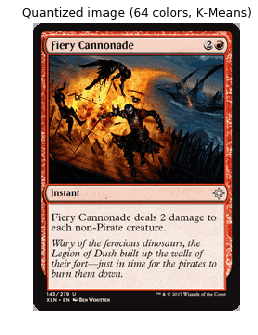

In [22]:
def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.show()

<h3>Compare to Input Data</h3>

In [26]:
test_img = Image.open("Data/test-images/fcTest.jpg")
test_img = np.array(test_img, dtype=np.float64) / 255

w, h, d = test_original_shape = tuple(test_img.shape)

test_img_array = np.reshape(test_img, (w * h, d))
test_img_array_sample = shuffle(test_img_array, random_state=0)[:1000]

# Apply Kmeans

test_kmeans = KMeans(n_clusters=numberClust, random_state=0)
test_kmeans.fit(test_img_array_sample)
test_labels = test_kmeans.predict(test_img_array)
print(test_kmeans.cluster_centers_)


[[ 0.06896222  0.06867527  0.05681492]
 [ 0.67294118  0.64522876  0.56653595]
 [ 0.37657952  0.32984749  0.26601307]
 [ 0.81546218  0.81098039  0.75943978]
 [ 0.92235294  0.7227451   0.39333333]
 [ 0.70065359  0.39281046  0.30849673]
 [ 0.97189542  0.93899782  0.87908497]
 [ 0.43594771  0.49869281  0.51013072]
 [ 0.17254902  0.1855615   0.17094474]
 [ 0.38088235  0.23235294  0.16078431]
 [ 0.20160428  0.12762923  0.0828877 ]
 [ 0.05087984  0.02765209  0.02564103]
 [ 0.77167756  0.73028322  0.64204793]
 [ 0.45697809  0.41845444  0.33010381]
 [ 0.25955882  0.33504902  0.36372549]
 [ 0.59934641  0.25751634  0.21045752]
 [ 0.66834734  0.50868347  0.41904762]
 [ 0.8245098   0.525       0.43382353]
 [ 0.27124183  0.22331155  0.1708061 ]
 [ 0.98431373  0.93823529  0.43627451]
 [ 0.8054902   0.57372549  0.3172549 ]
 [ 0.72592593  0.74901961  0.7416122 ]
 [ 0.33703704  0.37625272  0.3708061 ]
 [ 0.89444444  0.86405229  0.80065359]
 [ 0.27773933  0.14048443  0.07358708]
 [ 0.98588235  0.99254902

In [60]:
def makeClusters(n) :
    L=[]
    center0 = np.array([0, 0, 0])
    L.append(center0)
    centerFinal = np.array([255, 255, 255])
    for i in range(1, n-1) :
        center = (255*i)/(n-1)
        L.append(np.array([center, center, center]))
    L.append(centerFinal)
    return L

makeClusters(4)

[array([0, 0, 0]),
 array([ 85.,  85.,  85.]),
 array([ 170.,  170.,  170.]),
 array([255, 255, 255])]